#### TF.SnoqualmieData.ipynb
Karl Lapo October/2015

Exploring and processing Snoqualmie flux tower data


In [7]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
dir_data = '/Users/karllapo/gdrive/GroundObs/Snoqualmie/Raw/SNQ_Data/'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/TurbulenceFeedbacks/Graphics'
dir_out = '/Users/karllapo/gdrive/SnowHydrology/proj/TurbulenceFeedbacks/data/SNQ'

In [2]:
def calc_RH(p,q,T):
    RH = np.empty_like(T)
    if np.nanmin(T) < 200:
        T = T + 273.16
    T_0 = 273.16

    RH = .263*p*q* (np.exp( (17.67*(T-T_0)) / (T-29.65) ))**(-1)
    RH[RH > 100] = 100
    return(RH)

def calc_Tdew(T,RH):
    ## CHECKS
    if np.nanmax(T) > 100 or np.nanmin(T) > 40:
        raise ValueError('Air temperature must be in Celsius')

    if np.nanmax(RH) > 1 or np.nanmin(RH) < 0:
        RH = RH/100
        if np.nanmax(RH) > 1 or np.nanmin(RH) < 0:
            raise ValueError('Relative humidity must be a fraction on [0,1]')

    if not np.size(RH) == np.size(T):
        raise ValueError('Relative humidity and air temperature must have the same number of elements')

    ## ALGORITHM
    # When are we calculating with respect to frost or water?
    frost_ind = np.flatnonzero(T <= 0)
    water_ind = np.flatnonzero(T > 0)
    # Frost coefficients 
    b_frost = 22.587
    c_frost = 273.86
    # Water coefficients
    b_water = 17.625
    c_water = 243.03

    # Pre-allocate
    Tdew = np.empty_like(T)
    ## Calculate
    Tdew[frost_ind] = MagnusTetens(T[frost_ind],RH[frost_ind],b_frost,c_frost)
    Tdew[water_ind] = MagnusTetens(T[water_ind],RH[water_ind],b_water,c_water)

    return(Tdew)

## SUB-FUNCTION for actual expression
def MagnusTetens(T,RH,b,c):
    dew = (c*( np.log(RH) + (b * T)/(c + T) )) / ( b - np.log(RH) - (b * T)/(c + T) )
    return(dew)

In [3]:
##### Flux tower data
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y+':'+mo+':'+dy+'_'+hr+':'+mn+':'+s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

# pandas read (Dataframe)
os.chdir(dir_data+'Filled_Forcing')
datafile = 'Met_Forcing_SNQ_10_1_2012_5_11_2015.txt'
data = pd.read_csv(datafile,sep=r"\s*",header=None,\
                   parse_dates={'Datetime' : [0,1,2,3,4]},date_parser=parse,index_col='Datetime')
# Format
data.columns = ['seconds','precip','SWdwn','LWdwn','Tair','WIND','Press','QS']
data.drop('seconds', axis=1, inplace=True)
# RH
data['RH'] = calc_RH(data.Press.values,data.QS.values,data.Tair.values)
# Dew point temperature
data['Tdew'] = calc_Tdew(data.Tair.values-273.16,data.RH.values)
# Convert to xray Dataset
ds = xray.Dataset.from_dataframe(data)
ds = ds.rename({'Datetime': 'time'})

print(ds)

<xray.Dataset>
Dimensions:  (time: 45741)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    precip   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWdwn    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    LWdwn    (time) float64 286.9 286.9 286.5 286.5 286.5 286.5 286.5 286.5 ...
    Tair     (time) float64 279.0 279.0 279.0 279.2 279.4 279.4 279.1 278.9 ...
    WIND     (time) float64 0.068 0.126 0.06 0.126 0.045 0.099 0.199 0.116 ...
    Press    (time) float64 9.088e+04 9.086e+04 9.085e+04 9.085e+04 ...
    QS       (time) float64 0.005277 0.005341 0.005394 0.005419 0.005373 ...
    RH       (time) float64 83.35 84.34 85.05 84.36 82.46 83.76 84.16 84.74 ...
    Tdew     (time) float64 3.24 3.407 3.546 3.611 3.49 3.661 3.512 3.409 ...


/Users/karllapo/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [4]:
#### Supporting information
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y+':'+mo+':'+dy+'_'+hr+':'+mn+':'+s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

os.chdir(dir_data+'Quality_Controled')
datafile = 'SNQ_QC_30min_2013_2015.TSURF.csv'
support = pd.read_csv(datafile,sep=',',header=0,na_values=-9999,\
                   parse_dates={'Datetime' : [0,1,2,3,4]},date_parser=parse,index_col='Datetime')
support = support.rename({'Datetime': 'time'})
support = support.reindex(ds.time.values,fill_value=np.nan)
ds['Tsurf'] = (('time'),support.Tsrf_1)


In [9]:
print(ds)
os.chdir(dir_out)
ds.to_netcdf('SnoqualmieObs.wy2013.wy2015.nc')

<xray.Dataset>
Dimensions:  (time: 45741)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    precip   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SWdwn    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    LWdwn    (time) float64 286.9 286.9 286.5 286.5 286.5 286.5 286.5 286.5 ...
    Tair     (time) float64 279.0 279.0 279.0 279.2 279.4 279.4 279.1 278.9 ...
    WIND     (time) float64 0.068 0.126 0.06 0.126 0.045 0.099 0.199 0.116 ...
    Press    (time) float64 9.088e+04 9.086e+04 9.085e+04 9.085e+04 ...
    QS       (time) float64 0.005277 0.005341 0.005394 0.005419 0.005373 ...
    RH       (time) float64 83.35 84.34 85.05 84.36 82.46 83.76 84.16 84.74 ...
    Tdew     (time) float64 3.24 3.407 3.546 3.611 3.49 3.661 3.512 3.409 ...
    Tsurf    (time) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...


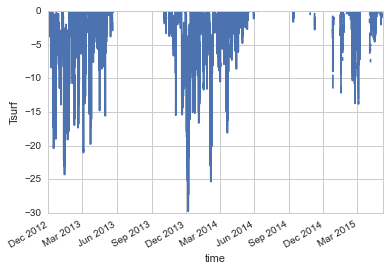

In [8]:
# Time series of raw data
ds.Tsurf.values[ds.Tsurf.values > 0] = np.nan
ds.Tsurf.plot()

<xray.DataArray 'Tsurf' (time: 574)>
array([-21.39417333, -21.75078   , -21.86962   , -22.27057667,
       -22.08016   , -21.98154333, -21.16288333, -19.73931333,
       -19.42958   , -20.64127   , -21.8532    , -22.77459333,
       -22.88076667, -23.08949667, -22.19694333, -19.49288667,
       -18.95777   , -20.36346333, -19.30539333, -19.19131   ,
       -20.00621   , -21.05638333, -21.41589   , -21.10824333,
       -23.64475333, -23.70779667, -23.74027667, -23.51422333,
       -23.72625333, -23.20469667, -23.93284   , -24.10273   ,
       -24.16187667, -24.11335667, -24.30846667, -23.85641   ,
       -21.24820333, -17.603     , -18.52754   , -21.40076333,
       -23.06628333, -21.38163   , -19.02166   , -18.38631667,
       -18.11828   , -16.12776667, -16.44753667, -18.30561667,
       -17.60672   , -16.47061667, -19.49527667, -20.31103667,
       -18.26268667, -19.02411   , -19.12986   , -19.01219333,
       -17.94734333, -14.56466333, -10.61567333, -10.71653667,
       -11.01832  